<a href="https://colab.research.google.com/github/revans011/classifier_accuracy/blob/main/One_classifier_one_unlabeled_dataset_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classifier accuracy using unlabeled data
This notebook has a Bayesian model and MCMC code for the one-classifier, one-unlabeled-dataset model to determine the confusion matrix and assesses the accuracy of binary classifiers on unlabeled data.

#Definition
One of the model parameters is the "prevalence" of the dataset.  *If the data were labeled*, "prevalence" is the proportion of $1$'s in the dataset. However, the data aren't labeled, so prevalence is a model parameter instead of a known constant. Prevalence comes from this model's origins in diagnostic test assesment and the unkown prevalence of disease in a population of animals.

#The prior distribtions
The prior distributions for the sensitivities, specificities, and prevalences are all Beta distributions. Even with an identifiable model, like the one presented here, sensible priors help MCMC convergence. Branscum et al. (2005) developed the very useful Windows app "BetaBuster" to help elicit Beta  distribution parameters. Alternatively, use this [website's](https://www.omnicalculator.com/statistics/beta-distribution) online calculator. The idea is to find Beta distribution parameters, $\alpha$ and $\beta$, that reflect resonable assumptions. 

For example, if a previouly trained supervised classifier is in the model, then its sensitivity and specificity were most likely assessed on a labeled dataset sometime previously and are good. Then it would be reasonable to pick Beta paramenters $\alpha$ and $\beta$ such that $Pr(x>0.5)=90\%$

#References
1. Evans, R. (2022). Confusion Matrices and Accuracy Statistics for Binary Classifiers Using Unlabeled Data: The Diagnostic Test Approach. arXiv:2208.12664 \[stat.ML\]

1. Branscum, A. J., Gardner, I. A., and Johnson, W. O. (2005). Estimation of diagnostic-test sensitivity and specificity through Bayesian modeling. Preventive Veterinary Medicine, 68, 145-163.

1. We used the [emcee](https://arxiv.org/abs/1202.3665) ensemble sampler for the MCMC

1. This paper set up the underpinnings:  \
Hui, Sui L., and Walter, S.D. (1980). Estimating the error rates of diagnostic tests. Biometrics 167-171.



Copyright (c) <2022>, <Richard Evans>
All rights reserved.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd
!pip install emcee
from scipy.stats import beta
from scipy.stats import binom
import emcee
np.seterr(all="ignore") #supresses  "the invalid value encountered in double_scalars lnpdiff = f + nlp - state.log_prob[j]" warning--it doesn't affect the MCMC


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.1 MB/s 


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#The model specification

In [ ]:


#The prior distribution for the sensitivity
def log_prior_seA(se):  
    a,b = 20,4
    if se<=0.0: 
      return -np.inf
    elif se>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(se,a,b))


#The prior distribution for the specificity
def log_prior_spA(sp):  
    a,b = 20,4
    if sp<=0.0: 
      return -np.inf
    elif sp>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(sp,a,b))




#The prior distribution for the prevalence
def log_prior_prev1(prev):  
    a,b = 1,1
    if prev<=0.0: 
      return -np.inf
    elif prev>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(prev,a,b))


#the likelihood
def log_binomial1(seA,spA,prev1):

    k = 90  #The data go here. k is the count of 1's in the prediction list
    n = 100 # the length of the prediction list      

    p = prev1*seA + (1-prev1)*(1-spA)  
    
    if p<=0.0: 
      return -np.inf
    elif p>=1.0: 
      return np.inf
    else: 
      return np.log(sp.binom.pmf(k, n=n, p=p))


#the log posterior distribtion
def log_post(theta):
    seA,spA,prev1 = theta
    sum_priors = log_prior_seA(seA) + log_prior_spA(spA) + \
                 log_prior_prev1(prev1)

    lnprobval = log_binomial1(seA,spA,prev1) + sum_priors
    if not np.isfinite(sum_priors):      #this if statement is from the emcee example
        return -np.inf
    return(lnprobval)



#Running the ensemble sampler

In [ ]:
%%time

ndim, nwalkers = 3, 9 #There are 3 dimensions (one sensitivity, one specificity, and one prevalence). I often use nwalkers = 3 x ndim

# Starting positions for the walkers.
p0 = [0.5 +(1e-2 * np.random.rand(ndim)) for i in range(nwalkers)]

#make the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)

#Run the sampler
_ = sampler.run_mcmc(p0, nsteps=100000)


CPU times: user 6min 31s, sys: 2.67 s, total: 6min 34s
Wall time: 6min 37s


The counts in the above table are the lengths of the Markov chains after burn in and thinning.

#Establishing convergence: Trace plots
There are many ways to verify that the Markov Chains are a representative sample from the posterior distribution. I used an overly simple approach here becuase the focus of this notebook is on the model specification, rather than a particular MCMC methodology.

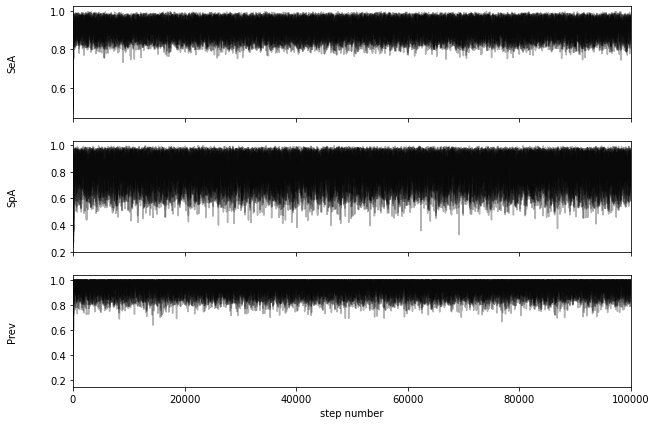

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["SeA", "SpA", "Prev"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Each plot above has *ndim* number of walkers

#Thin and remove the burn in 

In [ ]:
#A snippet from the emcee website
print(
    "Mean autocorrelation time: {0:.3f} steps (the number of steps needed to forget)".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 55.830 steps (the number of steps needed to forget)


In [ ]:
#For each step in the chain, I take the median across the walkers. That gives a single chain for each of the six parameters

thin = 50 #thin the chains to reduce autocorrelation. Pick a number larger than the mean autocorrelation time for thinning
burn_in =100


df_parameter_chains = pd.concat([pd.DataFrame(sampler.get_chain(thin=thin, discard=burn_in)[:,:,0]).median(axis=1),
                                pd.DataFrame(sampler.get_chain(thin=thin, discard=burn_in)[:,:,1]).median(axis=1),
                                pd.DataFrame(sampler.get_chain(thin=thin, discard=burn_in)[:,:,2]).median(axis=1)],axis=1)

df_parameter_chains.columns =['Sensitivity', 'Specificity', 'Prevalence']



In [ ]:
#A snippet from the emcee website
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.604


#Posterior summaries (point estimates) for classifier sensitivity, <br> specificity, and dataset prevalence
For example, for the classifier that produced the data for this analysis, we might use the medians and say the classifier's sensitivity is an appalling 0.499561


In [ ]:
#summary statistics from the estimated posterior distributions of the parameters
df_parameter_chains.describe().round(decimals=3).to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  Sensitivity &  Specificity &  Prevalence \\\\\n\\midrule\ncount &     1998.000 &     1998.000 &    1998.000 \\\\\nmean  &        0.911 &        0.832 &       0.958 \\\\\nstd   &        0.013 &        0.031 &       0.016 \\\\\nmin   &        0.866 &        0.720 &       0.887 \\\\\n25\\%   &        0.902 &        0.812 &       0.949 \\\\\n50\\%   &        0.911 &        0.834 &       0.959 \\\\\n75\\%   &        0.920 &        0.854 &       0.969 \\\\\nmax   &        0.951 &        0.932 &       0.993 \\\\\n\\bottomrule\n\\end{tabular}\n'

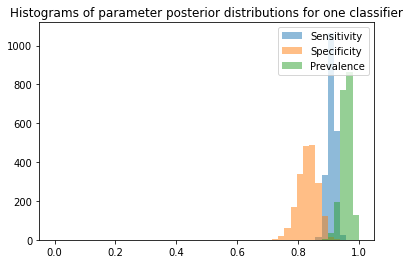

In [ ]:
#Some histograms
from matplotlib import pyplot

x = df_parameter_chains['Sensitivity']
y = df_parameter_chains['Specificity']
z = df_parameter_chains['Prevalence']

bins = np.linspace(0, 1, 50)

pyplot.hist(x, bins, alpha=0.5, label='Sensitivity')
pyplot.hist(y, bins, alpha=0.5, label='Specificity')
pyplot.hist(z, bins, alpha=0.5, label='Prevalence')
pyplot.legend(loc='upper right')
pyplot.title('Histograms of parameter posterior distributions for one classifier')
pyplot.show()

#Confusion Matrix

The numbers in the top row are the sensitivity and 1-sensitivity, and in the bottom row, 1-specificity and specificity. Simply multiply the matrix by a sample size and round the decimal if you prefer integers in the confusion matrix.

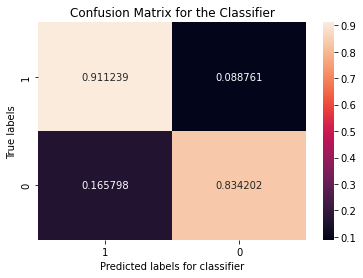

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


#make the elements of the confusion matrix
cm11 = df_parameter_chains['Sensitivity'].median()
cm12 = 1-df_parameter_chains['Sensitivity'].median()
cm21 = 1-df_parameter_chains['Specificity'].median()
cm22 = df_parameter_chains['Specificity'].median()


cm = np.array([[cm11,cm12],[cm21,cm22]])

#A snippet to plot a seaborn heatmap
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='f', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels for classifier');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for the Classifier'); 
ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);

#Accuracy summaries for classifier A
The real advantage of using the Bayesian approach is that it's easy to express uncertain about estimates. The table below uses the estimates of the posterior distributions (the Markov chain from the emcee sampler) to give summaries. For example, the standard deviations (std) of the accuracy statistics (e.g., F1) represents uncertainty about the mean. Likewise the 25th and 75th percentiles give uncertain about the median. 

In [ ]:
se_A = df_parameter_chains['Sensitivity']                 #rename to simplify construction of the summary table
sp_A = df_parameter_chains['Specificity']
prev_1 = df_parameter_chains['Prevalence']
ppv = (se_A * prev_1 /(se_A*prev_1 +((1-se_A)*(1-prev_1)))) #define the positive predictive value (ppv)


df_accuracy = pd.concat([se_A*prev_1 + (sp_A*(1-prev_1)),   #combine four accuacy statisitcs into a pandas dataframe
                      se_A,      
                      ppv,     
                      (2*ppv*se_A/(ppv+se_A))], axis=1)

df_accuracy.columns = ['Accuracy','Recall','PPV','F1']      #label the columns

df_accuracy.describe().round(decimals=3).to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  Accuracy &    Recall &       PPV &        F1 \\\\\n\\midrule\ncount &  1998.000 &  1998.000 &  1998.000 &  1998.000 \\\\\nmean  &     0.907 &     0.911 &     0.996 &     0.951 \\\\\nstd   &     0.012 &     0.013 &     0.002 &     0.007 \\\\\nmin   &     0.866 &     0.866 &     0.988 &     0.927 \\\\\n25\\%   &     0.899 &     0.902 &     0.995 &     0.946 \\\\\n50\\%   &     0.908 &     0.911 &     0.996 &     0.952 \\\\\n75\\%   &     0.916 &     0.920 &     0.997 &     0.956 \\\\\nmax   &     0.943 &     0.951 &     0.999 &     0.973 \\\\\n\\bottomrule\n\\end{tabular}\n'

#Discussion
The model specification presented in this notebook allows the estimation of senstivity and specificity using unlabeled data. The model has been used successfully in biostatistics for over 40 years. That said, the Markov chains may be highly correlated and caution is alway required running MCMC.